## Inference on partial correlation matrixes

Jacob L. Fine

Nov 3rd, 2025

Given a design matrix with $n$ observations each with $p$ features, the covariance matrix with respect to features is $p \times p$. The covaraince matrix tells us about dependencies between features in our data. Inverting the covariance matrix gives the 'precision matrix' which has interesting statistical properties and can be useful for applications in computational biology. In particular, by scaling each entry in the precision matrix, we can get the 'partial correlation' between pairs of features. The partial correlation between two random variables gives us a measure of their association where other covariates in the data are conditioned out. This is conceptually similar to 'regressing out' covariates with techniques that involve using the residuals in linear models.

In particular, given a design matrix $X_{n \times p}$, with a covariance matrix $\Sigma_{p \times p}$, the correlation coefficients $r_{ij}$ are defined as:

$r_{ij} = \frac{\Sigma_{ij}}{\sqrt{\Sigma_{ii}\Sigma_{jj}}} = \text{corr} (X_i,X_j)$

The precision matrix is defined as 

$\Theta = \Sigma^{-1}$ 

where each value in the matrix gives the partial correlation $\rho$ between each pair of features (off-diagonals), i.e., 

$\rho_{ij} = -\frac{\Theta_{ij}}{\sqrt{\Theta_{ii}\Theta_{jj}}}$.

This can also be expressed in terms of the conditional random variables:

$\rho_{ij} = \text{corr} (X_i,X_j|X_{-(i,j)})$

Where $X_{-(i,j)}$ is a notation to denote all features that are not $i$ or $j$. Also recall that each $X_i$ is one vector of $n$ observations over one of the features, i.e., $0 \leq i \leq p$. This is not to be confused with when $|x_i| = p$, i.e., when we assume the data are i.i.d. accross the rows with respect to all the features (they are drawn from the same joint density) for computing the likelihood function $L(\theta)= \prod_{i=0}^n f(x_i|\theta)$

Here, we will first simulate data with a knonw dependency structure and compute the partial correlation matrix, compared to the dependency structure. 

Reference: https://onlinelibrary.wiley.com/doi/10.1111/sjos.12675

To first demonstrate the difference between a regular correlation matrix and a partial correlation matrix, consider three random variables with the dependancy structure

$X_1 \rightarrow X_2 \rightarrow X_3$

This is a directed acyclic graph that encodes the following conditional independence structure:

$P(X_1, X_3|X_2) = P(X_1|X_2)P(X_3|X_2)$

In other words, $X_1$ is independent of $X_3$ given $X_2$, since any observed relationship between $X_1$ and $X_3$ is explained by each random variable's relationship to $X_2$.

We would then expect the partial correlation $\text{corr}(X_1,X_3|X_2)=0$

Let's apply this below.

In [5]:
import numpy as np
import pandas as pd

np.random.seed(2000127)
n = 500

# Some model of our data, so that we can encode the dependnecy structure.
X1 = np.random.randn(n)
X2 = 0.8 * X1 + np.random.randn(n) * 0.3
X3 = 0.8 * X2 + np.random.randn(n) * 0.3

# makes a df of these results
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3})

# makes a corr matrix of these data
corr_matrix = df.corr(method='pearson')
print("regular correlations:\n", corr_matrix, "\n")

# we can see that all of these variables correlate.

regular correlations:
           X1        X2        X3
X1  1.000000  0.937499  0.865672
X2  0.937499  1.000000  0.923757
X3  0.865672  0.923757  1.000000 



In [6]:
# now, lets apply what we've learned to get the precision matrix by inverting the covariance matrix

# given that same df generated from the DAG, let's get the covaraince and then precision matrix.
Sigma = np.cov(df.values, rowvar=False)
Theta = np.linalg.inv(Sigma) # simply invert the matrix 
# conforms we get the identity matrix back
np.round(Sigma @ Theta)

array([[ 1., -0., -0.],
       [-0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [7]:
d = np.sqrt(np.diag(Theta)) # gives us the values to scale by, in accordiance with the equation for partial correlation
partial_corr = -Theta / np.outer(d, d) # the outer product of the diagonals, gets the correct demoninator to normalize by (diagonals will become 1)
np.fill_diagonal(partial_corr, 1) # makes sure the diags are 1

print("partial correlations:\n", pd.DataFrame(partial_corr, index=df.columns, columns=df.columns))

# wow, so we can now see that X1 and X3 are in fact conditionally independent given X2!

partial correlations:
           X1        X2        X3
X1  1.000000  0.718892 -0.002626
X2  0.718892  1.000000  0.644010
X3 -0.002626  0.644010  1.000000


We will now apply this to the classic Sachs et al. (2005) paper: "Causal protein-signaling networks derived from multiparameter single-cell data" where interactions between 11 phosphorylated proteins & phospholipids from the following list were modelled, by determining the levels of each protein with flow cytometry.

While a Bayesian network was used in their paper (which captures directionality of interactions), for our purposes, we are only interested in which interactions are direct versus indirect, using the partial correlation. This is technically a case of a 'Markov random field'. Our aim is therefore to construct an undirected graph from the expression of each protein in each cels, i.e., a matrix of ~1000 cells by 11 proteins. We only want to assign edges to directly interacting proteins. Therefore, we can use the approaches described above.

The raw data from the study can be obtained from the following link:
https://www.science.org/doi/10.1126/science.1105809#supplementary-materials

We will now load all of the tables into one df, for downstream analysis and to construct the regulatory network. We will show how the partial correlation network is more informative than the standard correlation matrix.

In [8]:
import os
import warnings
warnings.filterwarnings("ignore") # for supressing warnings


# %cd "/Users/jacobfine/Downloads/" # cd into the directory we want

dfs_dict = {}

xls_dir = "./Data Files"  # cd into the direcotry with the files from the supps in the paper

# loop through each file in the directory
for filename in os.listdir(xls_dir):
    # looks for files with that ending
    if filename.endswith(".xls"):
        # creates the file path
        file_path = os.path.join(xls_dir, filename)
        try:
            # reads file
            df = pd.read_excel(file_path, sheet_name=0, engine="xlrd")

            # makes col names uppercase (since there were inconsistencies in their cases)
            df.columns = df.columns.str.upper()

            dfs_dict[filename] = df
            print(f"df loaded with shape = {df.shape}; name = {filename}")
        except Exception as e:
            print(f"Error in reading {filename}: {e}")

# concats the dfs, aligns cols by name 
df_sachs = pd.concat(dfs_dict.values(), axis=0, ignore_index=True, sort=False)

# converts non-numeric entries to NaN
df_sachs = df_sachs.apply(pd.to_numeric, errors='ignore')

df_sachs

df loaded with shape = (799, 11); name = 6. cd3cd28+u0126.xls
df loaded with shape = (853, 11); name = 1. cd3cd28.xls
df loaded with shape = (899, 11); name = 10. cd3cd28icam2+aktinhib.xls
df loaded with shape = (902, 11); name = 2. cd3cd28icam2.xls
df loaded with shape = (759, 11); name = 13. cd3cd28icam2+u0126.xls
df loaded with shape = (913, 11); name = 8. pma.xls
df loaded with shape = (911, 11); name = 3. cd3cd28+aktinhib.xls
df loaded with shape = (927, 11); name = 14. cd3cd28icam2+ly.xls
df loaded with shape = (723, 11); name = 4. cd3cd28+g0076.xls
df loaded with shape = (753, 11); name = 11. cd3cd28icam2+g0076.xls
df loaded with shape = (707, 11); name = 9. b2camp.xls
df loaded with shape = (848, 11); name = 7. cd3cd28+ly.xls
df loaded with shape = (810, 11); name = 5. cd3cd28+psitect.xls
df loaded with shape = (868, 11); name = 12. cd3cd28icam2+psit.xls


,PRAF,PMEK,PLCG,PIP2,PIP3,P44/42,PAKTS473,PKA,PKC,P38,PJNK
0,2436.0,3685.0,16.40,40.0,11.20,1.00,41.8,105.0,6.38,23.7,77.70
1,114.0,160.0,11.80,32.2,13.60,3.82,38.2,119.0,7.23,44.9,15.80
2,557.0,947.0,7.70,18.6,36.50,5.19,64.9,138.0,2.05,20.0,12.40
3,638.0,914.0,11.90,59.4,18.90,2.46,44.1,107.0,1.22,17.9,7.37
4,316.0,461.0,4.91,73.7,24.60,4.70,30.5,2017.0,25.90,49.6,15.80
...,...,...,...,...,...,...,...,...,...,...,...
11667,33.7,29.7,32.80,400.0,28.60,46.60,110.0,1263.0,11.90,34.9,16.50
11668,149.0,96.5,7.37,106.0,9.56,10.90,34.9,509.0,15.40,42.6,42.60
11669,30.8,19.6,1.00,154.0,14.10,11.40,56.7,965.0,3.79,38.2,10.40
11670,43.7,25.3,15.70,305.0,34.30,10.60,32.8,437.0,25.00,47.4,40.00


In [9]:
# lets now make the covariance and inverse covariance matrix

Sigma = np.cov(df_sachs.values, rowvar=False)
Theta = np.linalg.inv(Sigma) 

In [10]:
# as we've done before
d = np.sqrt(np.diag(Theta)) 
partial_corr = -Theta / np.outer(d, d)
np.fill_diagonal(partial_corr, 1) 

df_sachs_partial = pd.DataFrame(partial_corr) # gets the partial corr

df_sachs_corr = df_sachs.corr(method='pearson') # also gets the corr matrix

<Axes: >

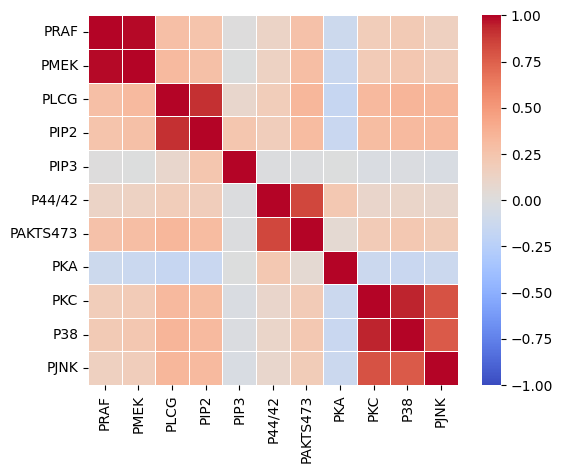

In [11]:
# to view the corr matrix
import seaborn as sns
sns.heatmap(df_sachs_corr, cmap="coolwarm", center=0, square=True, linewidths=0.5,vmin=-1,vmax=1)


<Axes: >

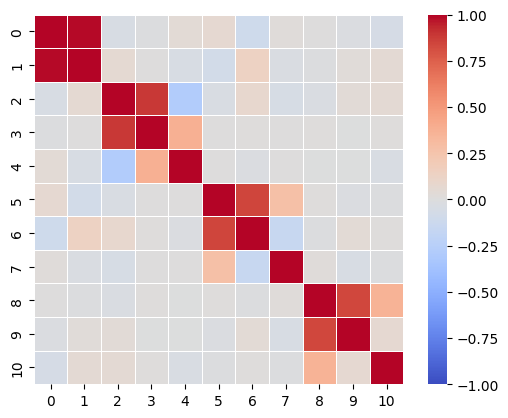

In [12]:
# now look at how much cleaner the partial corr matrix looks!

sns.heatmap(df_sachs_partial, cmap="coolwarm", center=0, square=True, linewidths=0.5,vmin=-1,vmax=1)

In practice, it is often hard to directly invert a covariance matrix, so we may wish to estimate it with numerical approximations. To estimate a precision matrix, numerical methods based on maximum likelihood estimation are useful. Here, we will implement a popular method for estimating the precision matrix, namely, the 'graphical lasso' (glasso). This method is particularly useful when we expect a sparse matrix for partial correlations, since it uses an L1 penalty which can shrink some partial correlations down to zero. The method also assumes that the data are multivariate normal. If the partial correlation is zero between any pair of features, then we can infer that the features are conditionally independent. 

The optimization problem that glasso solves is given by:

$\hat{\Theta} = \text{argmax}_\Theta ( \log \text{det } \Theta - \text{tr} ({\Sigma \Theta}) - \lambda\sum_{i,j}|\Theta_{ij}|)$

Here, $\lambda$ is the regularization parameter for L1. For applications, suppose we are interested in a regulatory network of genes and wish to compare their corrleation over multiple conditions/cells. 

In [13]:
from sklearn.covariance import GraphicalLassoCV # to import the GraphicalLasso object to use
import matplotlib.pyplot as plt 

# fits graphical lasso to data
model = GraphicalLassoCV()
model.fit(df_sachs.values)

# uses it to make the precision matrix
Theta = model.precision_

# as we've done before, gets us the partial corr matrix
d = np.sqrt(np.diag(Theta))
partial_corr = -Theta / np.outer(d, d)
np.fill_diagonal(partial_corr, 1)

# makes a df of it for interpretation
df_sachs_partial_lasso = pd.DataFrame(partial_corr, index=df_sachs.columns, columns=df_sachs.columns)


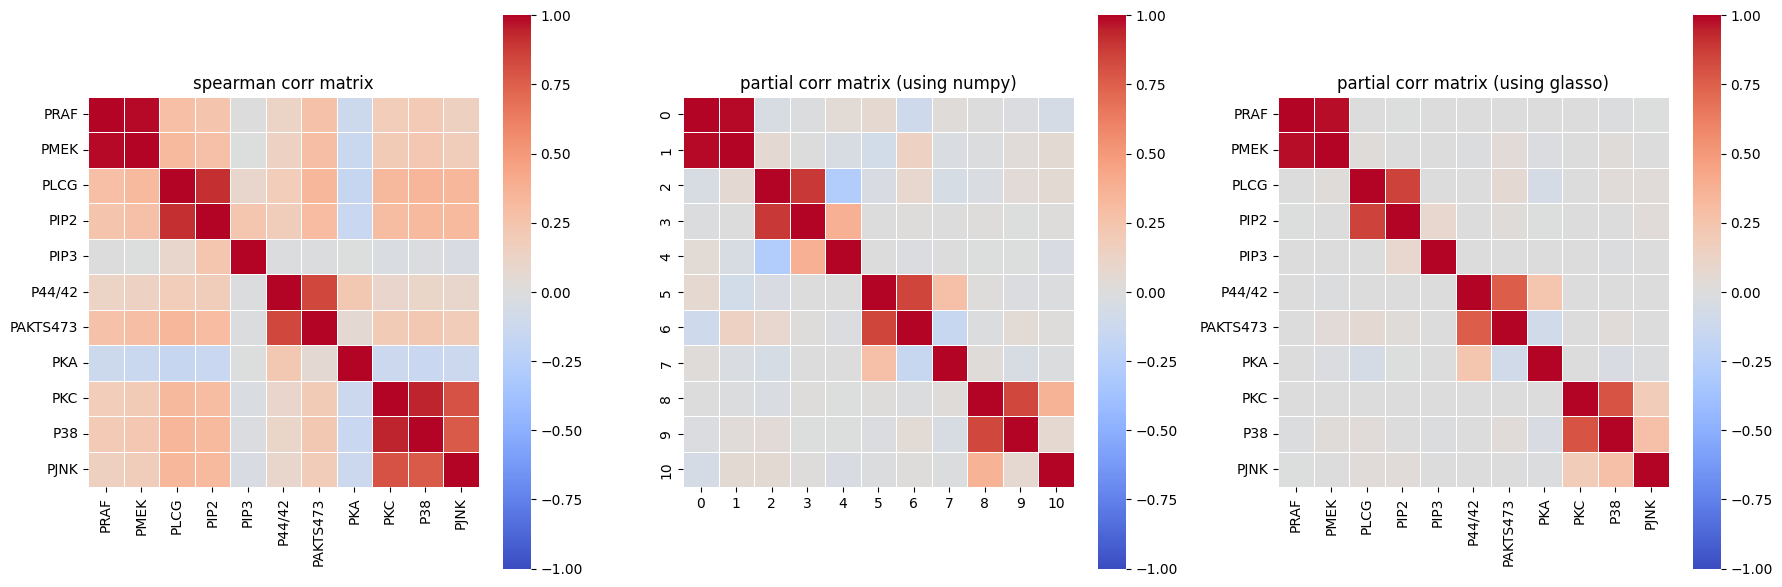

In [14]:
# now, let's visualize how all three compare

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# correlation matrix
sns.heatmap(df_sachs_corr, cmap="coolwarm", center=0, square=True,
            linewidths=0.5, vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title("spearman corr matrix")

# np.linalg.inv partial correlation
sns.heatmap(df_sachs_partial, cmap="coolwarm", center=0, square=True,
            linewidths=0.5, vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title("partial corr matrix (using numpy)")

# glasso partial correlation
sns.heatmap(df_sachs_partial_lasso, cmap="coolwarm", center=0, square=True,
            linewidths=0.5, vmin=-1, vmax=1, ax=axes[2])
axes[2].set_title("partial corr matrix (using glasso)")

plt.tight_layout()
plt.show()


As we can see, the density decreases when we use glasso, since the L1 regularization is shrinking some of the coefficients (i.e., the small ones) to zero. This effectively removes even more of the weaker interactions, leaving us with more confident results. We can then quantify just how density each matrix is by calculating the proportion of its 'non-zero' (or, non-trivially small) values.

In [15]:
def matrix_density(M, tol=1e-2):
    # the number of features
    p = M.shape[0]
    # defines the off diags
    off_diag = M[~np.eye(p, dtype=bool)]
    # defines non-zero as entries that have an absolute value above some tolerance
    nonzero = np.sum(np.abs(off_diag) > tol)
    density = nonzero / (p * (p - 1))
    return density

corr_density = matrix_density(df_sachs_corr.values)
partial_density = matrix_density(df_sachs_partial.values)
partial_lasso_density = matrix_density(df_sachs_partial_lasso.values)


print(f"corr matrix density: {corr_density:.3f}")
print(f"partial corr matrix density: {partial_density:.3f}")
print(f"glasso partial correlation matrix density: {partial_lasso_density:.3f}")


corr matrix density: 0.945
partial corr matrix density: 0.764
glasso partial correlation matrix density: 0.436


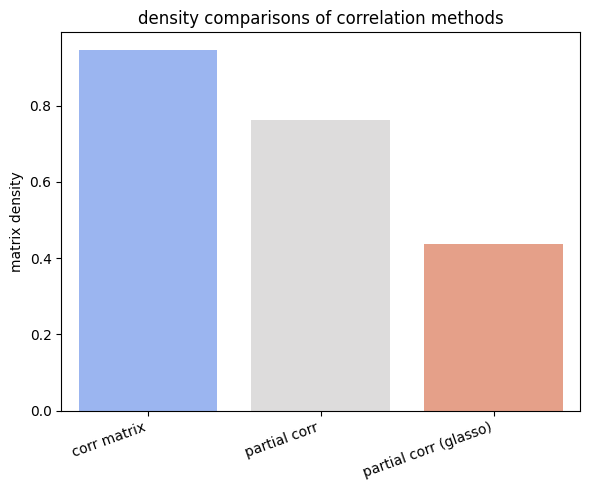

In [16]:
# we can plot this too
df_density = pd.DataFrame({
    "matrix": ["corr matrix", "partial corr", "partial corr (glasso)"],
    "density": [corr_density, partial_density, partial_lasso_density]
})

plt.figure(figsize=(6, 5))
sns.barplot(data=df_density, x="matrix", y="density", palette="coolwarm")
plt.ylabel("matrix density")
plt.xlabel("")
plt.title("density comparisons of correlation methods")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()
